# Set up

In [1]:
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import re
import pickle
import seaborn as sns
from pandas.plotting import parallel_coordinates


from scipy.stats import gaussian_kde
from statsmodels.graphics.tsaplots import plot_acf

# Pyro diagnostics
from pyro.ops.stats import gelman_rubin, split_gelman_rubin, effective_sample_size


# Data

In [2]:
def extract_data(csv_path, col_name = "estimated_params"):
    df = pd.read_csv(csv_path)
    estimated_params_list = df[col_name].apply(ast.literal_eval).tolist()
    return np.array(estimated_params_list)

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [4]:
L_GP_params = extract_data("PlotData/L.GP_21_result.csv")

L_DKGP_params = extract_data("PlotData/L.DKGP_21_result.csv")

L_MGP_params = extract_data("PlotData/L.MGP_21_result.csv")

L_DKMGP_params = extract_data("PlotData/L.DKMGP_21_result.csv")

VGP_params = extract_data("PlotData/VGP_21_result.csv")

MVGP_params = extract_data("PlotData/MVGP_21_result.csv")

DGP_params = extract_data("PlotData/DGP_21_point_result.csv")

DNN_params = extract_data("PlotData/DNN_21_result.csv")

# Function

In [5]:
def load_specific_format_data(folder, n_samples):
    """
    专门读取 {'param_0': tensor, ...} 格式的数据
    返回形状: (100, 1200, 10) -> (样本ID, 后验采样ID, 参数维度)
    """
    # 预分配内存
    all_posteriors = np.zeros((n_samples, N_POSTERIOR, N_DIMS))
    
    print(f"{n_samples}...")
    
    for i in range(n_samples):
        file_path = os.path.join(folder, f'result_{i+1}.pkl')
        
        if not os.path.exists(file_path):
            print(f"{file_path}did not exist.")
            continue
            
        with open(file_path, 'rb') as f:
            # data 是一个字典: {'param_0': tensor([...]), ...}
            data_dict = pickle.load(f)
        
        # 将字典转换为 (1200, 10) 的 numpy 数组
        # 我们必须显式循环 0-9，以确保参数顺序正确
        sample_matrix = []
        for dim in range(N_DIMS):
            key = f'param_{dim}'
            if key not in data_dict:
                raise ValueError(f"{file_path} lack {key}")
            
            # 提取 tensor 并转为 numpy
            # .detach().cpu().numpy() 是处理 tensor 的通用安全写法
            tensor_data = data_dict[key]
            numpy_data = tensor_data.detach().cpu().numpy()
            
            sample_matrix.append(numpy_data)
        
        # sample_matrix 目前是 list of 10 arrays (each 1200 length)
        # 使用 column_stack 变成 (1200, 10)
        sample_matrix = np.column_stack(sample_matrix)
        
        # 存入大数组
        all_posteriors[i, :, :] = sample_matrix

    print("Shape:", all_posteriors.shape)
    return all_posteriors

In [6]:
def get_point_estimates(samples):
    """
    输入: samples (1200,) 一维数组
    输出: mean, median, map_estimate
    """
    # 1. Mean
    mu = np.mean(samples)
    
    # 2. Median (50th percentile)
    med = np.median(samples)
    
    # 3. MAP (Mode) - 通过 KDE 寻找峰值
    try:
        # 使用高斯核密度估计拟合分布
        kde = gaussian_kde(samples)
        # 生成密集的 x 网格
        x_grid = np.linspace(np.min(samples), np.max(samples), 500)
        # 找到密度最大的 x
        density = kde(x_grid)
        map_est = x_grid[np.argmax(density)]
    except:
        # 如果样本方差为0等极端情况，退化为中位数
        map_est = med
        
    return mu, med, map_est

In [7]:
def split_chain(chain_tensor: torch.Tensor):
    """
    将单链样本拆成两半，形成两条“伪链”
    输入: Tensor[N]
    输出: (Tensor[N//2], Tensor[N//2])
    """
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]


def visualize_posterior_1d_params(
    single_chain_samples: dict,
    *,
    true_params_tensor=None,        # <- 新增：torch Tensor[D]，比如 test_x[0]
    bins=15,
    acf_lags=40,
    clip_percentiles=(0.5, 99.5),
    xlim=None,
):
    """
    single_chain_samples: dict[name -> Tensor[N]]
    true_params_tensor: Tensor[D]，若提供，会在 trace/hist 上标出真实值
    对每个参数：split Rhat/ESS + trace + hist+KDE+quantiles + ACF
    """

    # --- display name mapping (theta_0..theta_9 -> Ca_1..Cb_5) ---
    param_labels = ["Ca_1","Cb_1","Ca_2","Cb_2","Ca_3","Cb_3","Ca_4","Cb_4","Ca_5","Cb_5"]
    name_map = {f"theta_{i}": param_labels[i] for i in range(len(param_labels))}
    name_map.update({f"param_{i}": param_labels[i] for i in range(len(param_labels))})

    def display_name(p: str) -> str:
        return name_map.get(p, p)

    def parse_index(p: str):
        # 只对 theta_7 / param_7 这种形式返回 index
        try:
            head, tail = p.split("_", 1)
            if head in ("theta", "param"):
                return int(tail)
        except Exception:
            return None
        return None

    # 真实参数向量准备
    if true_params_tensor is not None:
        if not torch.is_tensor(true_params_tensor):
            true_vec = torch.tensor(true_params_tensor, dtype=torch.float32).detach().flatten().cpu()
    else:
        true_vec = None

    # 整理成 mcmc_samples：param -> Tensor[2, n_half]
    mcmc_samples = {}
    for param, samples in single_chain_samples.items():
        if samples.ndim != 1:
            raise ValueError(f"{param} should be 1D Tensor[N], got shape {tuple(samples.shape)}")
        chain_a, chain_b = split_chain(samples)
        mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)  # [2, n_half]

    # 诊断和可视化
    for param, samples_chains in mcmc_samples.items():
        disp = display_name(param)

        idx = parse_index(param)
        true_val = None
        if (true_vec is not None) and (idx is not None) and (0 <= idx < true_vec.numel()):
            true_val = float(true_vec[idx].item())

        rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
        split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
        ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)

        if true_val is None:
            print(f"{disp}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
        else:
            print(f"{disp}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}, true = {true_val:.6g}")

        # --- Trace + Histogram/KDE ---
        plt.figure(figsize=(12, 4))

        # Trace
        plt.subplot(1, 2, 1)
        for i in range(2):
            plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)

        if true_val is not None:
            plt.axhline(true_val, linestyle="--", linewidth=2, label="True value", color="green")  # 真实值水平线

        plt.title(f"Trace Plot for {disp}")
        plt.xlabel("Sample Index")
        plt.ylabel(disp)
        plt.legend()

        # Histogram + KDE + Quantiles
        plt.subplot(1, 2, 2)
        all_samps = samples_chains.reshape(-1).cpu().numpy()

        p_lo, p_hi = clip_percentiles
        xmin, xmax = np.percentile(all_samps, [p_lo, p_hi])

        # 确保真实值在线性范围内（避免被裁掉看不到）
        if true_val is not None:
            xmin = min(xmin, true_val)
            xmax = max(xmax, true_val)
            # 给一点边距
            pad = 0.02 * (xmax - xmin + 1e-12)
            xmin, xmax = xmin - pad, xmax + pad

        plt.hist(all_samps, bins=bins, density=True, alpha=0.7, color='gray')

        # KDE（样本太少/方差太小有时会报错，所以做个保护）
        if np.std(all_samps) > 0 and len(all_samps) > 5:
            kde = gaussian_kde(all_samps)
            x_grid = np.linspace(xmin, xmax, 200)
            plt.plot(x_grid, kde(x_grid), linewidth=2)

        qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
        for q in qs:
            plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)

        if true_val is not None:
            plt.axvline(true_val, linewidth=2, label="True value", color="green")  # 真实值竖线

        if xlim is not None:
            plt.xlim(*xlim)
        else:
            plt.xlim(xmin, xmax)

        plt.title(f"Histogram + 2.5/50/97.5% Quantiles ({disp})")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # --- ACF（仅第一“伪链”） ---
        plt.figure(figsize=(6, 4))
        plot_acf(samples_chains[0].cpu().numpy(), lags=acf_lags)
        plt.title(f"ACF for {disp} (Chain 1)")
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.tight_layout()
        plt.show()



# Plots

In [ ]:
base_dir = "PlotData"

model_files = {
    "L_GP": "L.GP_21_result.csv",
    "L_MGP": "L.MGP_21_result.csv",
    "L_DKGP": "L.DKGP_21_result.csv", 
    "L_DKMGP": "L.DKMGP_21_result.csv",
    "VGP": "VGP_21_result.csv",
    "MVGP": "MVGP_21_result.csv",
    "DGP": "DGP_21_point_result.csv",
    "DNN": "DNN_21_result.csv"
}

## pre

In [ ]:
mse_results = {}
for model, filename in model_files.items():
    est = extract_data(os.path.join(base_dir, filename), col_name = 'test_preds')

    mse_results[model] = np.mean((est - Y_test_21) ** 2)



mse_df = pd.DataFrame.from_dict(mse_results, orient='index', columns=['MSE'])
mse_df.index.name = 'Model'
mse_df = mse_df.reset_index()


print(mse_df)


## Single vs. Multi

In [ ]:
mse_dict = {}
for model, filename in model_files.items():
    est = extract_data(os.path.join(base_dir, filename))

    mse_per_row = np.mean((est - X_test) ** 2, axis=1)
    mse_dict[model] = mse_per_row



mse_df = pd.DataFrame(mse_dict)


In [ ]:
mse_df.mean()

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
plt.ylabel("Mean Squared Error per Sample")
plt.title("Model Comparison")
plt.grid(True, linestyle='--', linewidth=0.5)
# plt.ylim(0, 0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
ax.set_yscale('log')
ax.set_ylabel("MSE per Sample (log scale)")
ax.set_title("Comparison with Log-scaled")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Local vs. Global

In [17]:
# DATA_FOLDER = 'PlotData/L.DKMGP_21_mcmc_result'    # 1500
# DATA_FOLDER = 'PlotData/MVGP_21_mcmc_result'       # 1200
DATA_FOLDER = 'PlotData/DNN_21_mcmc_result'          # 1200
N_SAMPLES = 120
N_POSTERIOR = 1200
N_DIMS = 10

param_labels = ["Ca_1","Cb_1","Ca_2","Cb_2","Ca_3","Cb_3","Ca_4","Cb_4","Ca_5","Cb_5"]

In [18]:
posterior_samples = load_specific_format_data(DATA_FOLDER, N_SAMPLES)

120...
Shape: (120, 1200, 10)


In [10]:
true_params = X_test

In [ ]:
N_SAMPLES = posterior_samples.shape[0]
N_DIMS = posterior_samples.shape[2]


est_mean = np.zeros((N_SAMPLES, N_DIMS))
est_median = np.zeros((N_SAMPLES, N_DIMS))
est_map = np.zeros((N_SAMPLES, N_DIMS))

print("Mean, Median, MAP")
for i in range(N_SAMPLES):
    for d in range(N_DIMS):
        s = posterior_samples[i, :, d]
        mu, med, mode = get_point_estimates(s)
        
        est_mean[i, d] = mu
        est_median[i, d] = med
        est_map[i, d] = mode

In [ ]:
post_mean = est_map # MAP 作为最终点估计
# post_mean = np.mean(posterior_samples, axis=1) # 后验均值
lower_ci = np.percentile(posterior_samples, 2.5, axis=1)  # 95% HDI 下界
upper_ci = np.percentile(posterior_samples, 97.5, axis=1) # 95% HDI 上界

# A. RMSE (均方根误差)
rmse = np.sqrt(np.mean((post_mean - true_params)**2, axis=0))

# B. Bias (偏差)
bias = np.mean(post_mean - true_params, axis=0)

# C. Coverage Probability (覆盖率)
# 检查真实值是否在 95% 区间内
is_covered = (true_params >= lower_ci) & (true_params <= upper_ci)
coverage = np.mean(is_covered, axis=0)

# 打印文本报告
print("\n" + "="*60)
print(f"{'Dim':<5} | {'RMSE':<10} | {'Bias':<10} | {'Coverage (Target: 0.95)':<25}")
print("-" * 60)
for i in range(N_DIMS):
    flag = ""
    if coverage[i] < 0.90: flag = "⚠️ Under"
    if coverage[i] > 0.99: flag = "⚠️ Over"
    print(f"{i:<5} | {rmse[i]:<10.4f} | {bias[i]:<10.4f} | {coverage[i]:<6.2f} {flag}")
print("="*60 + "\n")


# ==========================================
# 4. 可视化
# ==========================================



plt.style.use('seaborn-v0_8-whitegrid')
fig1, ax1 = plt.subplots(figsize=(7, 6))

ax1.scatter(true_params.flatten(), post_mean.flatten(),
            alpha=0.3, s=10, c='royalblue')

min_val = min(true_params.min(), post_mean.min())
max_val = max(true_params.max(), post_mean.max())
ax1.plot([min_val, max_val], [min_val, max_val],
         'r--', lw=2, label='Perfect Fit')

ax1.set_xlabel('True Parameter Value')
ax1.set_ylabel('Posterior Mean Estimate')
ax1.set_title(f'Global Accuracy (All Params)\nOverall RMSE: {np.mean(rmse):.4f}')
ax1.legend()
fig1.tight_layout()
plt.show()


# -------------------------
# 图 2: Coverage Bar Plot
# -------------------------
fig2, ax2 = plt.subplots(figsize=(9, 4.8))

x_pos = np.arange(N_DIMS)
bars = ax2.bar(x_pos, coverage, color='#69b3a2', alpha=0.8, edgecolor='black')
ax2.axhline(0.95, color='r', linestyle='--', linewidth=2, label='Target (0.95)')

ax2.set_ylim(0, 1.1)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(param_labels, rotation=45, ha="right")
ax2.set_xlabel("Parameter")
ax2.set_ylabel('Coverage Probability')
ax2.set_title('Uncertainty Calibration Check')

for i, bar in enumerate(bars):
    if coverage[i] < 0.9:
        bar.set_color('#d62728')
        bar.set_alpha(0.6)

ax2.legend()
fig2.tight_layout()
plt.show()


# -------------------------
# 图 3: Bias Boxplot
# -------------------------
fig3, ax3 = plt.subplots(figsize=(9, 4.8))

bias_distribution = post_mean - true_params
sns.boxplot(data=bias_distribution, ax=ax3, orient='h', palette="Set2")

ax3.axvline(0, color='r', linestyle='--')
ax3.set_yticks(np.arange(len(param_labels)))
ax3.set_yticklabels(param_labels)
ax3.set_ylabel("Parameter")
ax3.set_xlabel('Bias: (MAP - True)')
ax3.set_title('Bias Distribution (MAP Check)')
fig3.tight_layout()
ax3.set_xlim(-0.5, 0.5)
plt.show()


# -------------------------
# 图 4: Recovery Plot for Param_0 (or target_dim)
# -------------------------
fig4, ax4 = plt.subplots(figsize=(12, 5.5))

target_dim = 0
sort_indices = np.argsort(true_params[:, target_dim])

sorted_true  = true_params[sort_indices, target_dim]
sorted_mean  = post_mean[sort_indices, target_dim]
sorted_lower = lower_ci[sort_indices, target_dim]
sorted_upper = upper_ci[sort_indices, target_dim]

x_axis = np.arange(N_SAMPLES)
ax4.plot(x_axis, sorted_true, 'r-', linewidth=2, label='True Value')
ax4.fill_between(x_axis, sorted_lower, sorted_upper, color='gray', alpha=0.3, label='95% Credible Interval')
ax4.scatter(x_axis, sorted_mean, s=15, color='black', alpha=0.7, label='Posterior Mean')

ax4.set_title(f'Detailed Recovery Check for Param_{target_dim} (Sorted by True Value)')
ax4.set_xlabel('Sample Index')
ax4.set_ylabel('Value')
ax4.legend()

fig4.tight_layout()
plt.show()

In [19]:
def compute_crps_energy(samples, truth):
    """
    基于 Energy Score 公式计算一组样本的 CRPS
    输入:
        samples: (S,) 1D array, 后验采样 (例如 1200 个)
        truth: float, 真实值
    输出:
        crps: float
    """
    # 1. 第一项: 绝对误差的期望 E[|X - y|]
    term1 = np.mean(np.abs(samples - truth))
    
    # 2. 第二项: 样本间差异的期望 E[|X - X'|]
    # 为了加速计算，我们使用排序后的技巧 (Hersbach decomposition) 
    # 或者直接广播 (S < 2000 时广播很快)
    
    # 方法 A: 广播法 (代码简单，S=1200 时内存占用约 11MB，完全可以接受)
    # samples[:, None] - samples[None, :] 生成 (1200, 1200) 的矩阵
    term2 = np.mean(np.abs(samples[:, None] - samples[None, :]))
    
    return term1 - 0.5 * term2

# ==========================================
# 批量计算 CRPS
# ==========================================
# 假设 posterior_samples 形状为 (100, 1200, 10)
# 假设 true_params 形状为 (100, 10)

N_SAMPLES = posterior_samples.shape[0] # 100
N_DIMS = posterior_samples.shape[2]    # 10

crps_results = np.zeros((N_SAMPLES, N_DIMS))

print("开始计算 CRPS (这可能需要几秒钟)...")
for i in range(N_SAMPLES):
    for d in range(N_DIMS):
        s = posterior_samples[i, :, d] # 取出 1200 个样本
        t = true_params[i, d]          # 取出 1 个真实值
        crps_results[i, d] = compute_crps_energy(s, t)

print("CRPS 计算完成。")

# 计算每个维度的平均 CRPS
mean_crps_per_dim = np.mean(crps_results, axis=0)

# 打印结果
print("\n=== CRPS Summary (Lower is Better) ===")
print(f"{'Dim':<5} | {'Mean CRPS':<10}")
print("-" * 20)
for d in range(N_DIMS):
    print(f"{d:<5} | {mean_crps_per_dim[d]:<10.4f}")

开始计算 CRPS (这可能需要几秒钟)...
CRPS 计算完成。

=== CRPS Summary (Lower is Better) ===
Dim   | Mean CRPS 
--------------------
0     | 0.0415    
1     | 0.0563    
2     | 0.0516    
3     | 0.0827    
4     | 0.0292    
5     | 0.0462    
6     | 0.0361    
7     | 0.0757    
8     | 0.0229    
9     | 0.0392    


C:\Users\r4718\AppData\Local\Temp\ipykernel_29456\3637363032.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(param_labels, rotation=45, ha="right")


<Figure size 1800x600 with 0 Axes>

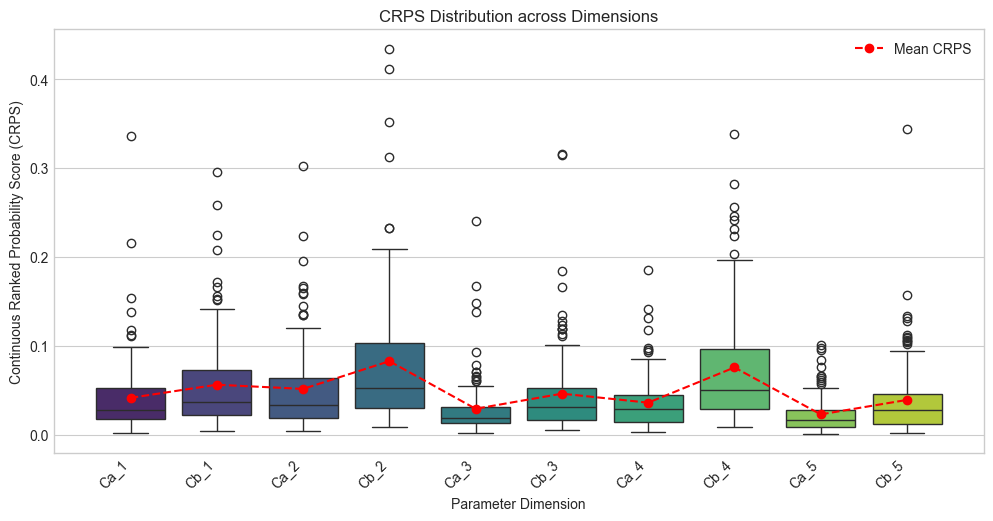

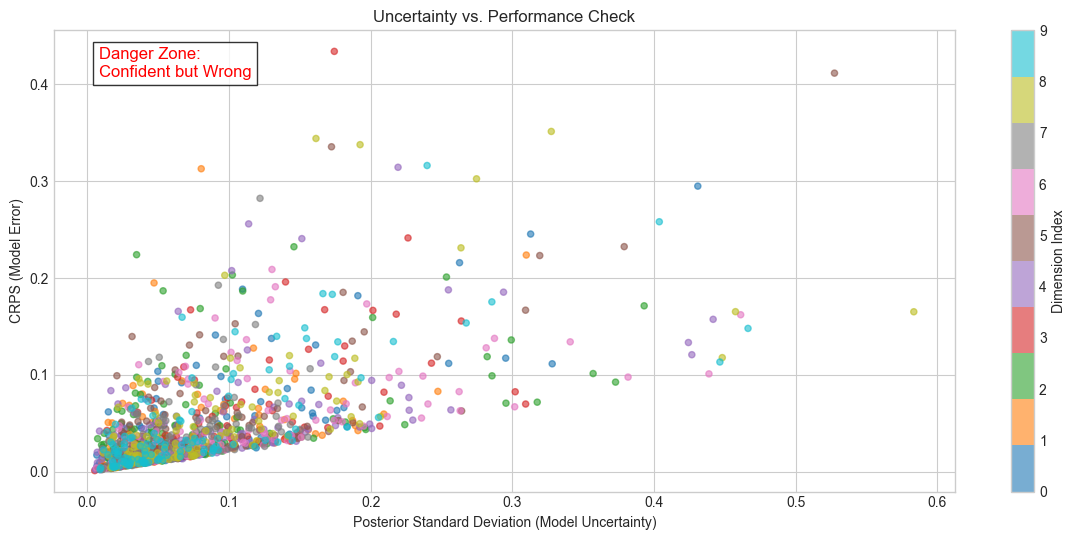

In [20]:
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(18, 6))

# --- 子图 1: 各维度的 CRPS 箱线图 ---
fig1, ax1 = plt.subplots(figsize=(12, 5.5))
sns.boxplot(data=crps_results, ax=ax1, palette="viridis")
ax1.set_xlabel('Parameter Dimension')
ax1.set_xticklabels(param_labels, rotation=45, ha="right")
ax1.set_ylabel('Continuous Ranked Probability Score (CRPS)')
ax1.set_title('CRPS Distribution across Dimensions')
# 标出平均值
ax1.plot(range(N_DIMS), mean_crps_per_dim, 'r--', marker='o', label='Mean CRPS')
ax1.legend()

# ax1.set_ylim(0, 0.5) 
plt.show()



fig2, ax2 = plt.subplots(figsize=(12, 5.5))
posterior_std = np.std(posterior_samples, axis=1) # (100, 10)

# 展平以便画散点图
x_std = posterior_std.flatten()
y_crps = crps_results.flatten()
# 我们可以根据维度上色，看看是否有特定维度表现异常
dim_labels = np.repeat(np.arange(N_DIMS), N_SAMPLES)

scatter = ax2.scatter(x_std, y_crps, c=dim_labels, cmap='tab10', alpha=0.6, s=20)
ax2.set_xlabel('Posterior Standard Deviation (Model Uncertainty)')
ax2.set_ylabel('CRPS (Model Error)')
ax2.set_title('Uncertainty vs. Performance Check')
plt.colorbar(scatter, label='Dimension Index', ax=ax2)

# 添加对角线参考 (仅作为视觉引导，非严格数学边界)
# 如果点都在左上角 (低方差，高CRPS)，说明模型过度自信且错误
ax2.text(0.05, 0.9, 'Danger Zone:\nConfident but Wrong', transform=ax2.transAxes, 
         color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

fig2.tight_layout()
plt.show()

In [ ]:
row_abs_sum = np.abs(bias_distribution).sum(axis=1)
np.argsort(-row_abs_sum)[:5]

### mcmc plot

In [ ]:
with open("PlotData/DNN_21_mcmc_result/result_2.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [ ]:
with open("PlotData/L.DKMGP_21_mcmc_result/result_2.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [ ]:
with open("PlotData/MVGP_21_mcmc_result/result_2.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [ ]:
import GP_functions.Tools as Tools

loaded_samples = torch.load("mcmc_RealCase_final_mcmc_infer_2block_independent.pt", map_location='cpu')

posterior_samples = Tools.extract_vector_params_from_mcmc(
    loaded_samples,
    key="params",
    param_names=[f"theta_{i}" for i in range(10)]  # 你也可以用真实参数名
)

In [ ]:
visualize_posterior_1d_params(
    posterior_samples,
    # true_params_tensor=X_test[1],
    true_params_tensor=None,
    bins=15,
    acf_lags=40,
    clip_percentiles=(0.5, 99.5),
    xlim=None, 
)

### test

In [ ]:
ROOT = Path("PlotData")


PKL_PATTERN = re.compile(r"result_(\d+)\.pkl", re.IGNORECASE)

true_params = X_test

have_true = True


In [ ]:
rows: list[dict[str, float]] = []
error_records: list[pd.DataFrame] = []  # for per‑sample error distributions

for model_dir in sorted(ROOT.iterdir()):
    if not model_dir.is_dir():
        continue

    model_name = model_dir.name
    print(f"Scanning {model_name} …")

    pkl_files = sorted(
        (p for p in model_dir.glob("result_*.pkl") if PKL_PATTERN.match(p.name)),
        key=lambda p: int(PKL_PATTERN.search(p.name).group(1))
    )

    for pkl_path in pkl_files:
        run_id = int(PKL_PATTERN.search(pkl_path.name).group(1))

        with pkl_path.open("rb") as fh:
            posterior_dict = pickle.load(fh)

        # (n_draws, 10)
        samples = np.column_stack([
            np.asarray(posterior_dict[f"param_{i}"], dtype=float).ravel()
            for i in range(10)
        ])

        theta_star = true_params[run_id - 1]

        # ── 2.1  Per‑run metrics ──────────────────────────────────────────
        post_mean = samples.mean(axis=0)
        rmse = float(np.sqrt(((post_mean - theta_star) ** 2).mean())) if have_true else np.nan

        lo, hi = np.percentile(samples, [2.5, 97.5], axis=0)
        cover95 = float(((theta_star >= lo) & (theta_star <= hi)).mean()) if have_true else np.nan

        mean_post_sd = float(samples.std(axis=0).mean())

        rows.append({
            "model": model_name,
            "run": run_id,
            "rmse": rmse,
            "cover95": cover95,
            "post_sd": mean_post_sd,
            **{f"phi{i+1}": float(theta_star[i]) for i in range(10)},
        })

        # ── 2.2  Collect per‑sample error for NEW violin plot ─────────────
        if have_true:
            err = samples - theta_star  # shape (n_draws,10)
            df_err = pd.DataFrame(err, columns=[f"phi{i+1}" for i in range(10)])
            df_err = df_err.melt(var_name="param", value_name="error")
            df_err.insert(0, "model", model_name)
            error_records.append(df_err)

print(f"\nLoaded {len(rows)} runs across {len(rows)//120 if rows else 0} models.")

# ------------------------------------------------------------
# 3  DATAFRAME & CSV OUTPUT
# ------------------------------------------------------------

df = pd.DataFrame(rows).sort_values(["model", "run"])
(df if have_true else df.drop(columns=["rmse", "cover95"]))\
    .to_csv(ROOT / "all_runs.csv", index=False)
print("Data table written → all_runs.csv")

# ------------------------------------------------------------
# 4  VISUALISATIONS
# ------------------------------------------------------------

sns.set_theme(style="whitegrid", context="talk")

if have_true:
    # 4.1  RMSE distribution per model
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x="model", y="rmse", palette="Set2", showfliers=False)
    sns.stripplot(data=df, x="model", y="rmse", color="k", size=3, alpha=0.4)
    plt.title("RMSE distribution per model")
    plt.tight_layout()
    plt.savefig(ROOT / "rmse_box.png", dpi=150)

# # 4.2  Parallel‑coordinates (parameters + scaled RMSE if available)
# sc_df = df.copy()
# scale_cols = [f"phi{i}" for i in range(1, 11)] + (["rmse"] if have_true else [])
# for c in scale_cols:
#     span = sc_df[c].max() - sc_df[c].min()
#     sc_df[c] = (sc_df[c] - sc_df[c].min()) / (span + 1e-12)

# plt.figure(figsize=(12, 6))
# parallel_coordinates(
#     sc_df[["model", *scale_cols]],
#     class_column="model", alpha=0.3, linewidth=0.8
# )
# plt.xticks(rotation=45)
# plt.title("Parallel‑coordinates: 10‑D true parameters" + (" + scaled RMSE" if have_true else ""))
# plt.tight_layout()
# plt.savefig(ROOT / "parallel_coords.png", dpi=150)

# # 4.3  PCA scatter (point size ∝ RMSE when available)
# feat_cols = [f"phi{i}" for i in range(1, 11)]
# pca = PCA(n_components=2).fit(df[feat_cols])
# df["PC1"], df["PC2"] = pca.transform(df[feat_cols]).T
# size = 40 + 260 * (df["rmse"] - df["rmse"].min()) / (df["rmse"].max() - df["rmse"].min() + 1e-12) if have_true else 60

# plt.figure(figsize=(6, 5))
# sns.scatterplot(
#     data=df, x="PC1", y="PC2", hue="model", size=size,
#     palette="Set2", sizes=(40, 300) if have_true else None,
#     alpha=0.8, edgecolor="k", legend="brief"
# )
# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
# plt.title("PCA of true parameters" + ("\n(point size ∝ RMSE)" if have_true else ""))
# plt.tight_layout()
# plt.savefig(ROOT / "pca_scatter.png", dpi=150)

# 4.4  NEW: Violin plot of posterior‑sample errors per parameter × model
if have_true and error_records:
    err_df = pd.concat(error_records, ignore_index=True)

    plt.figure(figsize=(16, 8))
    sns.violinplot(data=err_df, x="param", y="error", hue="model",
                   palette="Set2", split=False, cut=0, inner="quartile")
    plt.axhline(0, color="k", lw=.8, ls="--")
    plt.ylabel("Posterior sample − true value")
    plt.title("Distribution of posterior‑sample errors\n(10 parameters × 3 models)")
    plt.tight_layout()
    plt.savefig(ROOT / "error_violin.png", dpi=150)

print("Figures saved: rmse_box.png, parallel_coords.png, pca_scatter.png" + (", error_violin.png" if have_true else ""))

In [ ]:
err_df  

In [ ]:
error_records

# END